In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from scope import computations as cmp
from scope import clustering as cl
from scope import pre_match as pm
from scope import visualizations as vi
data=torch.load('embryo_rep.pt',weights_only=False)

In [3]:
import random
def setup_seed(seed: int = 42, deterministic: bool = False):

    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False  
        
seed = 42
setup_seed(seed=seed)


In [4]:
def remove_duplicates(tensor):
    unique_tensor = torch.unique(tensor, dim=0, return_inverse=False)
    return unique_tensor

data_lst = data['um']
data_lst_no_duplicates = [remove_duplicates(cells) for cells in data_lst]


def rep(day_list,high=500):
    day_list_new=[]
    for c in day_list:
        dif=high-c.shape[0]
        if dif>0:
            indice=torch.randint(0, c.size(0), (dif,))
            result=torch.cat([c,c[indice]],dim=0)
            day_list_new.append(result)
        else:
            day_list_new.append(c)     
    return day_list_new
 

# data_lst = rep(data_lst)
time_steps = [0,1,2,3,4,5,6,7,8,9,10,12,14,16]

meta=[[time_steps[i]]*len(data_lst[i]) for i in range(len(time_steps))]
meta=np.concatenate(meta)

In [5]:
cluster_centers, labels_list, best_k = cl.kmeans_auto([remove_duplicates(d.cuda()) for d in data_lst],tol=1e-4,method='calinski_harabasz',max_k=5)
print(best_k)

[1, 5, 2, 5, 5, 5, 2, 5, 5, 5, 4, 5, 5, 5]


In [6]:
max_variance_differences = cmp.max_adjacent_covariance_diagonal_differences([remove_duplicates(cells) for cells in data_lst])
print(max_variance_differences)
eps_func = cmp.piecewise_eps_function(time_steps, max_variance_differences,snr=0.9,min_eps=0.5) 

[0.005971173915629606, 0.00640080010383652, 1.0834361382319402, 1.827516616921954, 3.797834635327587, 4.4636375723136545, 0.5791272772820415, 2.2987567773115454, 1.805595282671737, 2.346076634777317, 8.988687556896089, 9.270964769777418, 16.2418944505661]


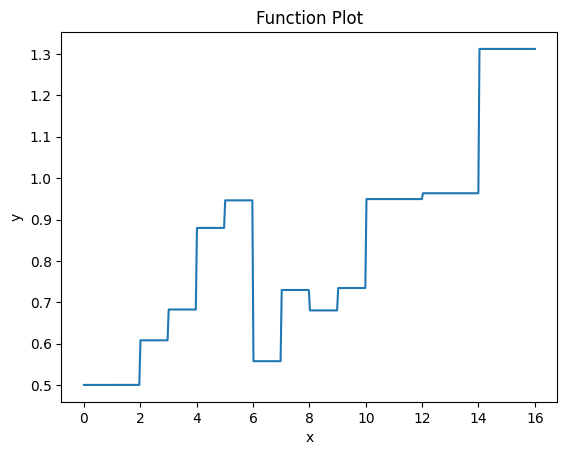

In [7]:
x = np.linspace(time_steps[0], time_steps[-1], 400)

y = [eps_func(x_i) for x_i in x]

plt.plot(x, y)

plt.title('Function Plot')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

INFO: Preparing data for visualization...
INFO: No UMAP model provided. Plotting the first two dimensions.


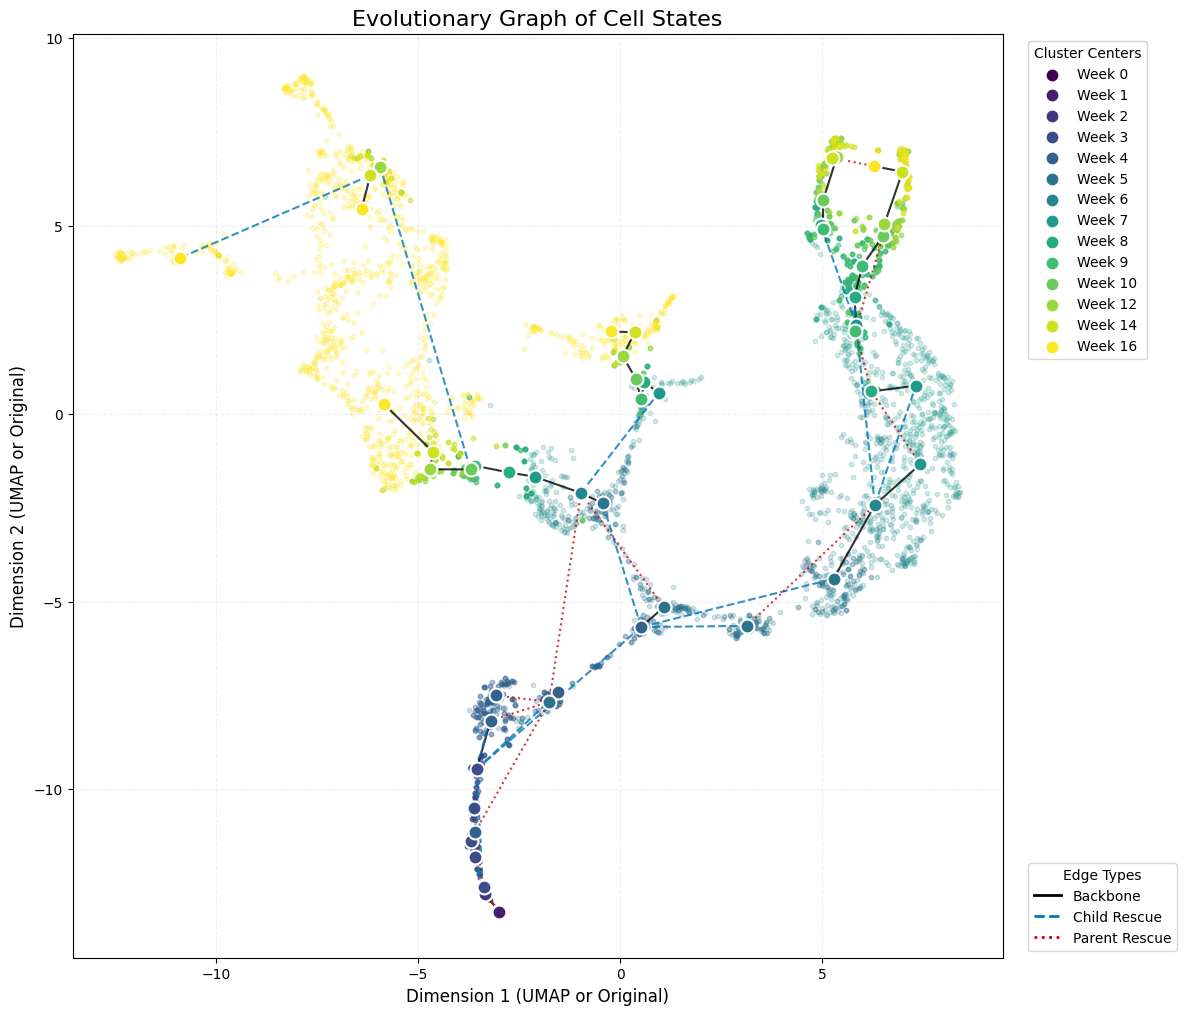

In [8]:

all_points_map, msf_edges = pm.calculate_evolutionary_graph([c.cpu().numpy() for c in cluster_centers],metric='euclidean')
vi.visualize_full_evolution(
    raw_data=[d.cpu().numpy() for d in data_lst],
    centers=[c.cpu().numpy() for c in cluster_centers],
    all_points_map=all_points_map,
    edges=msf_edges,
    time_labels=['Week ' + str(t) for t in time_steps],
    save_path='./embryo_results/evolution_graph'
)

Merging nodes (1, 0) and (1, 1) at time 1...
Merging nodes (1, 2) and (1, 3) at time 1...
Merging nodes (1, 4) and (1, 'm0') at time 1...
Merging nodes (1, 'm1') and (1, 'm2') at time 1...
Merging nodes (3, 1) and (3, 2) at time 3...
Merging nodes (3, 3) and (3, 4) at time 3...
Merging nodes (3, 'm4') and (3, 'm5') at time 3...
Merging nodes (4, 0) and (4, 3) at time 4...
Merging nodes (4, 4) and (4, 'm7') at time 4...
Merging nodes (5, 0) and (5, 2) at time 5...
Merging nodes (5, 1) and (5, 4) at time 5...
Merging nodes (7, 1) and (7, 4) at time 7...
Merging nodes (9, 0) and (9, 4) at time 9...
Re-indexing nodes to continuous integers...
Graph simplification and re-indexing complete.
INFO: Preparing data for visualization...
INFO: No UMAP model provided. Plotting the first two dimensions.


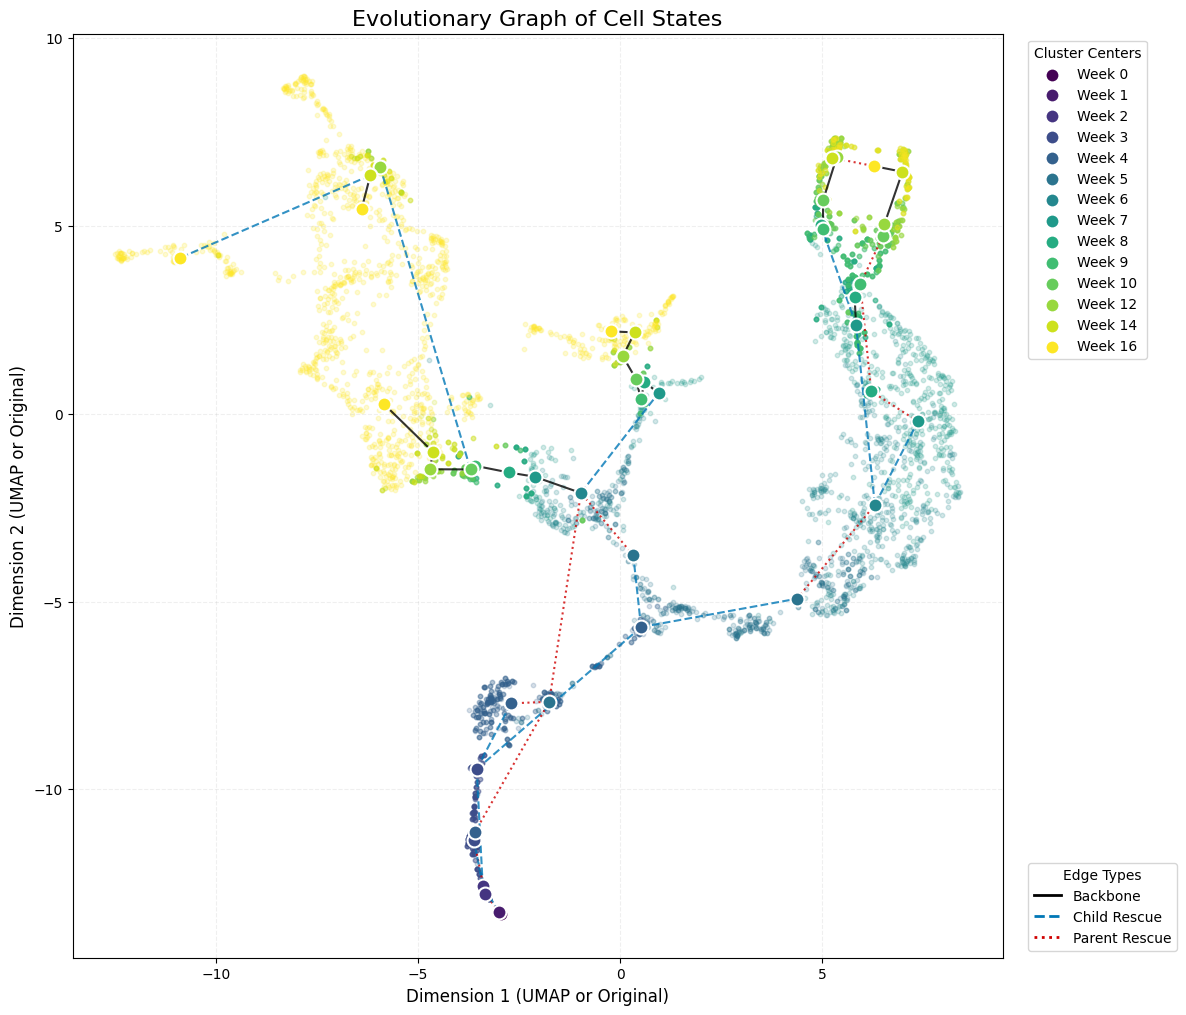

In [9]:
label_list_for_train = [cl.assign_labels(d.cuda(),cluster_centers[i].cuda()) for i, d in enumerate(data_lst)]
populations_map = cmp.count_cluster_samples(label_list_for_train)

all_points_map, cluster_centers, msf_edges = pm.simplify_evolutionary_graph(all_points_map, populations_map, msf_edges, epsilon_merge=10, theta_topo=0.5, metric='euclidean')
vi.visualize_full_evolution(
    raw_data=[d.cpu().numpy() for d in data_lst],
    centers=[c for c in cluster_centers],
    all_points_map=all_points_map,
    edges=msf_edges,
    time_labels=['Week ' + str(t) for t in time_steps],
    save_path='./embryo_results/evolution_graph_simplified'
)
cluster_centers = [torch.from_numpy(c) for c in cluster_centers]

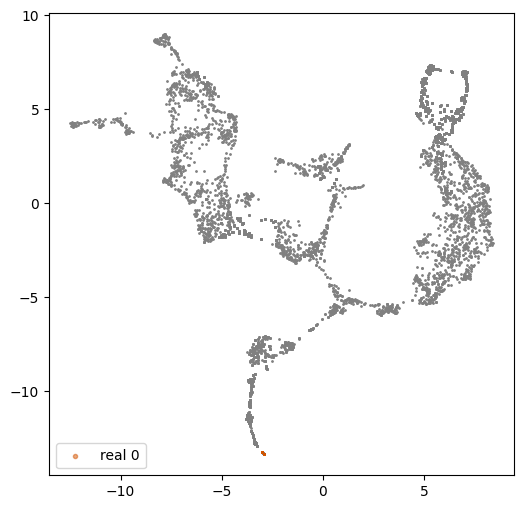

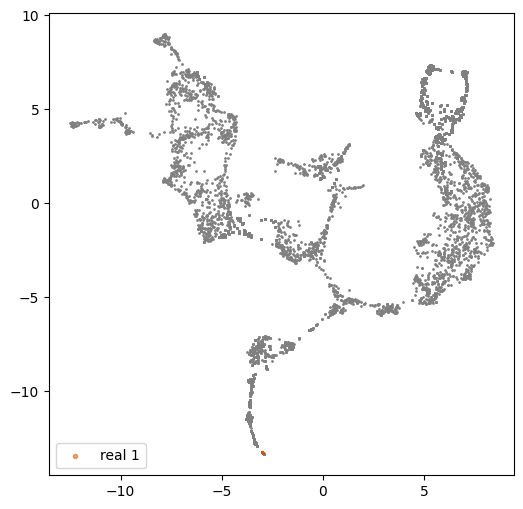

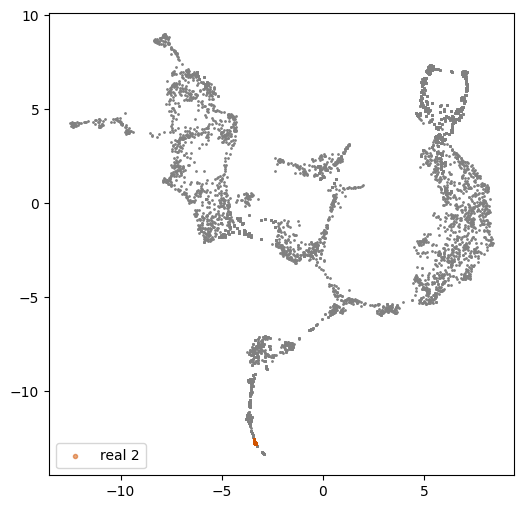

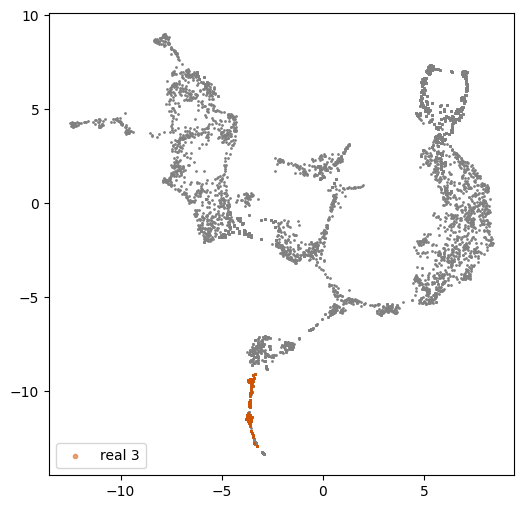

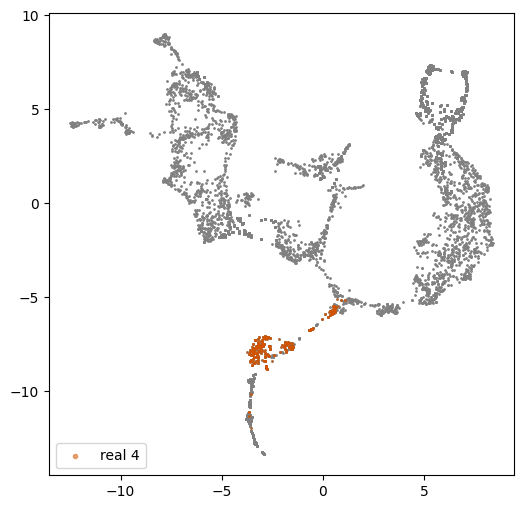

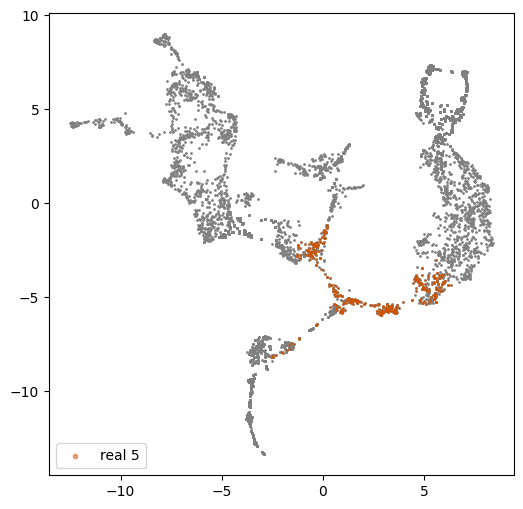

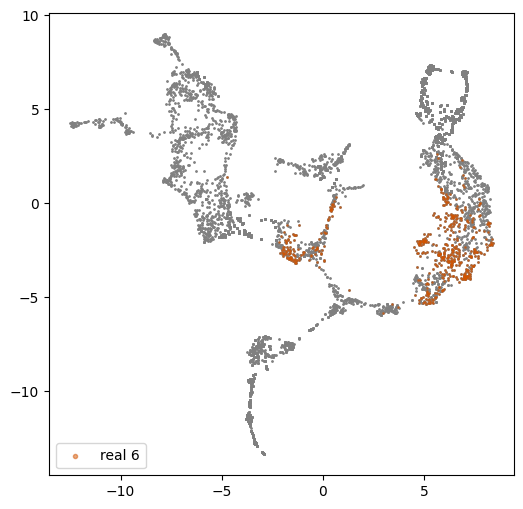

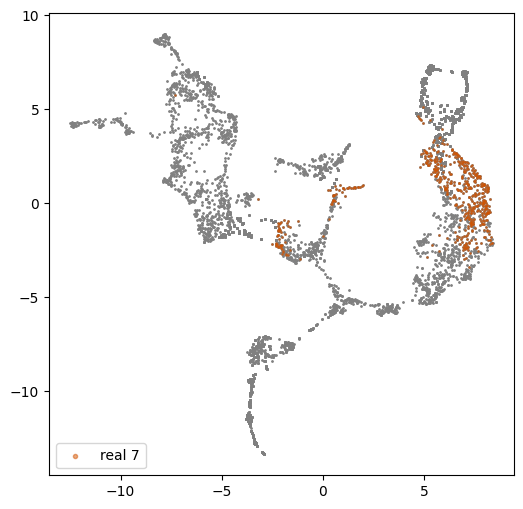

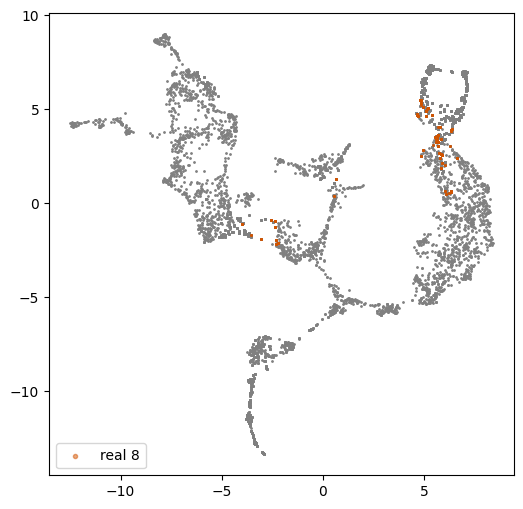

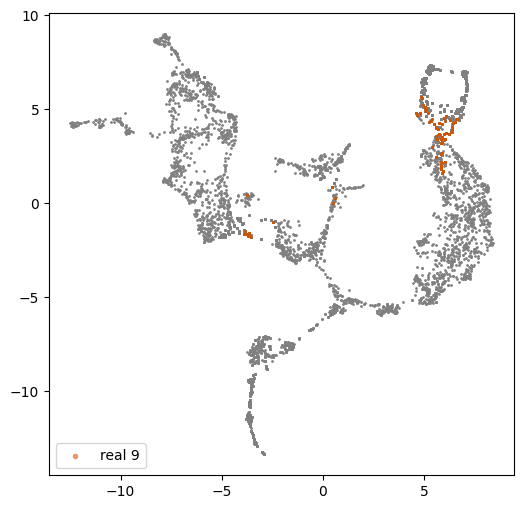

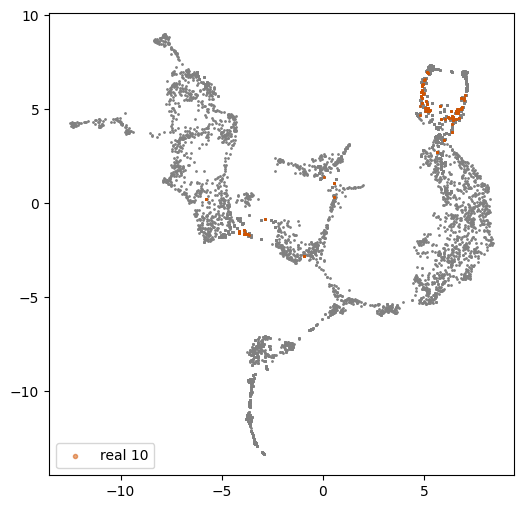

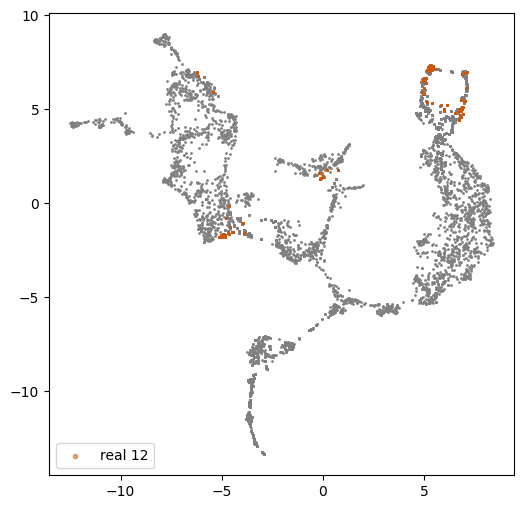

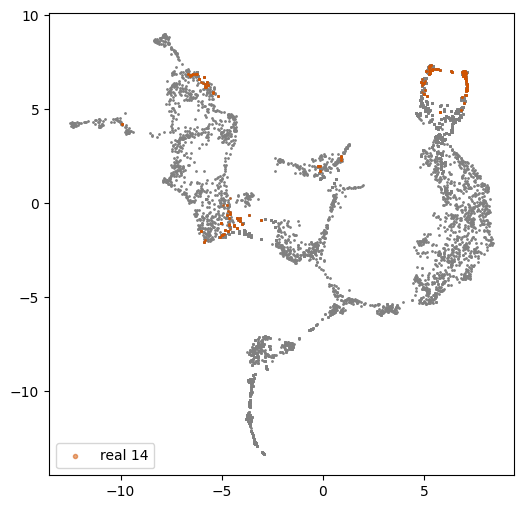

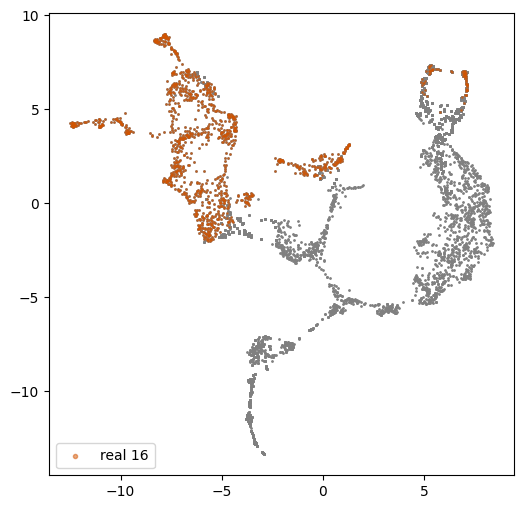

In [10]:
vi.visualize_populations(data_lst,time_steps,save_path='./embryo_results/raw_data')

In [11]:
import scope.datasets as ds

label_list_for_train = [cl.assign_labels(d.cuda(),cluster_centers[i].cuda()) for i, d in enumerate(data_lst)]

In [12]:
import scope
from scope import model

steps_each_day = 8
steps = 16*steps_each_day
# eps = lambda t: np.exp(0.1 * t) 
eps = eps_func
eps_test = eps
sb_object=model.sb_muti_model(data_lst,time_steps,N_pretraining=400,N_finetuning=400,backbone_lr=1e-3,finetuning_lr=1e-3,hiden_size=32,n_layers=2,
                              steps=steps,eps=eps,early_stop=True,patience=32,B=128,lambda_=0,save=True,record_gap=2,save_path='model_history/embryo_prematched',
                              prematched=True, label_list=label_list_for_train, edges=msf_edges, weighting_strategy='enos', beta=0.999)

INFO: 从演化图中找到了 19 条长度为 14 的有效路径（演化蓝图）。
defaultdict(<class 'float'>, {2: 0.21510862923200022, 1: 0.2247700055620517, 0: 0.18641610046612997, 3: 0.19056680919740343, 4: 0.18313845554241487})


In [13]:
print(sb_object.delta_t)

0.125


processed: 246:  62%|██████▏   | 246/400 [09:49<06:08,  2.39s/it, loss=194.75002415072166, loss_fore=213.26987408673125, loss_back=176.23017421471226]


Early stopping at epoch 246


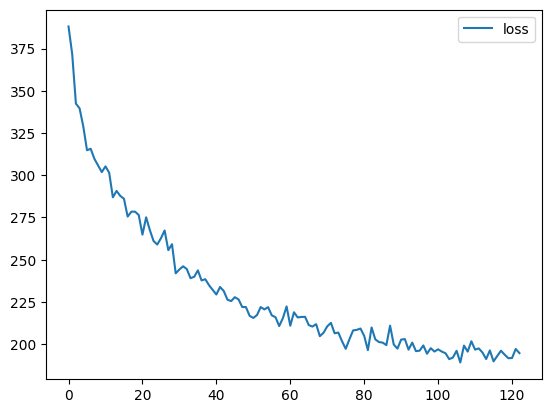

In [14]:
sb_object.backbone_train()

In [15]:
fore_base=sb_object.eval_fore(data_lst[0].cuda().double(),sb_object.v_fore)

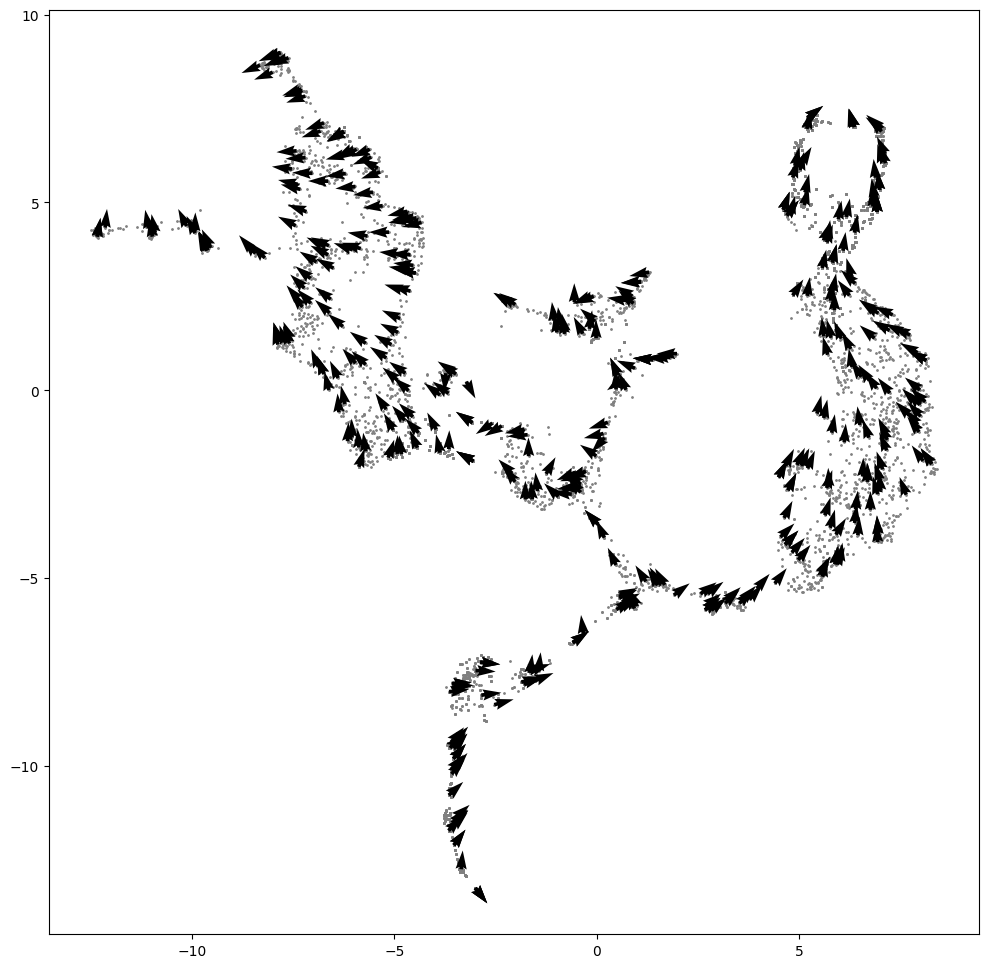

In [16]:
vi.visualize_drift_func([d.cuda() for d in data_lst],np.concatenate(data_lst),sb_object,meta,save_path='./embryo_results/drift_backbone',xg_lower_bound=-15,xg_upper_bound=10,yg_lower_bound=-15,yg_upper_bound=10)

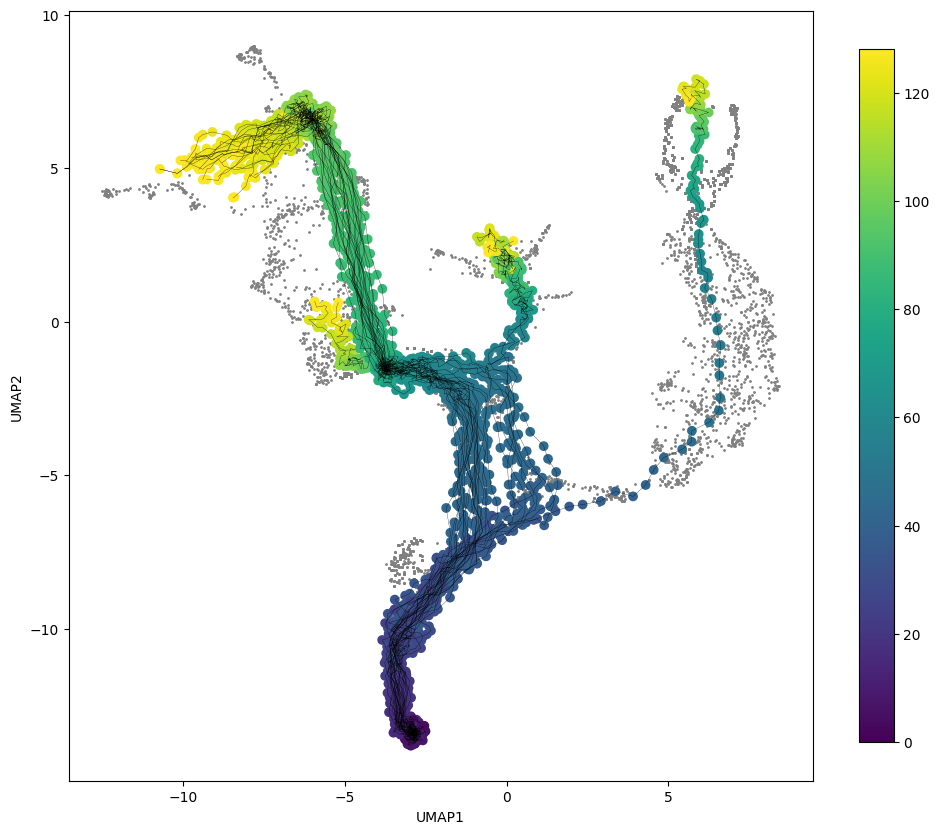

In [17]:
vi.visualize_generated_trajectories(data_lst,fore_base,save_path='./embryo_results/generated_trajectories_backbone')

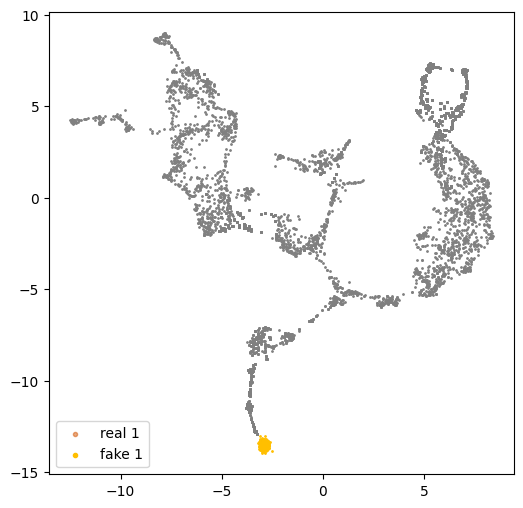

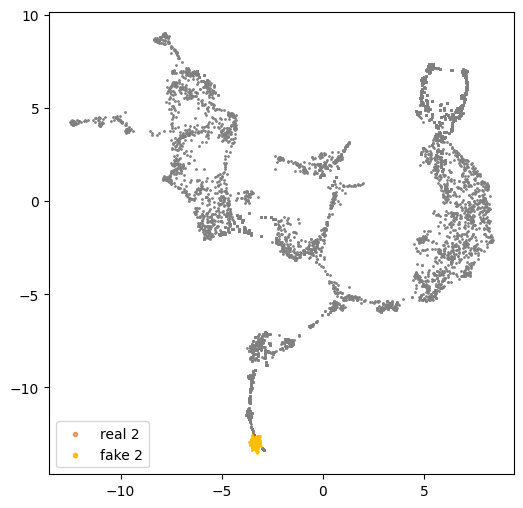

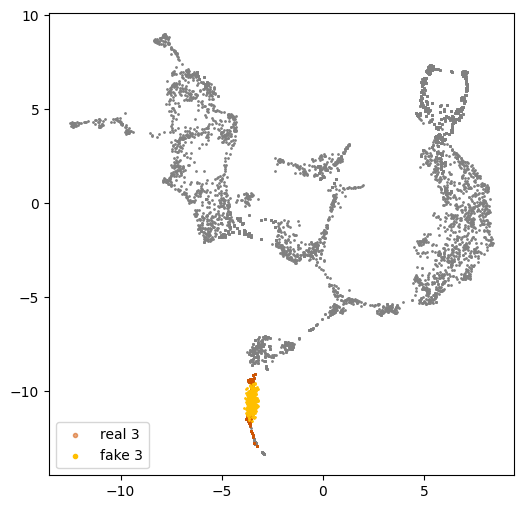

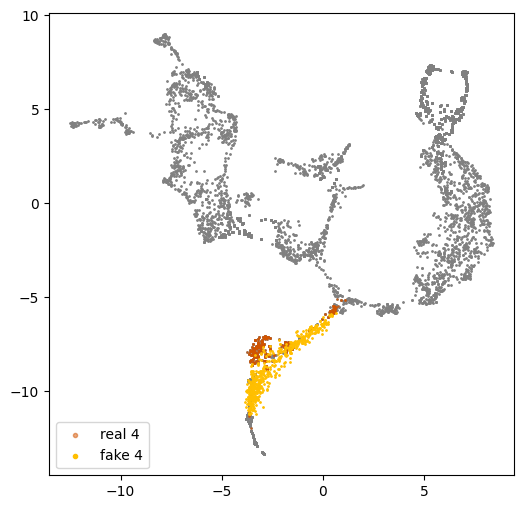

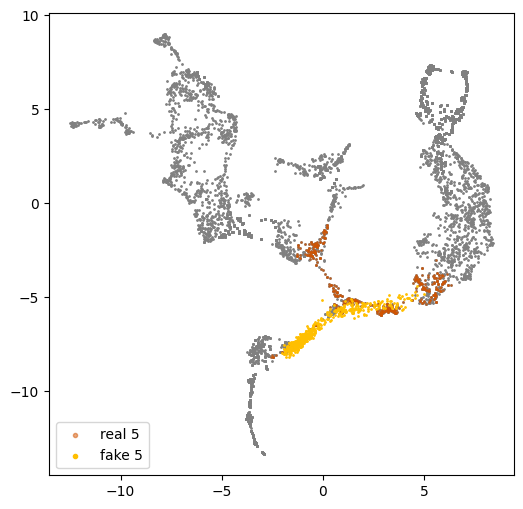

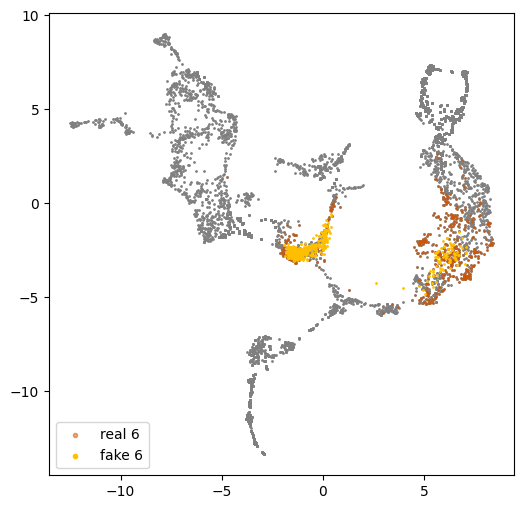

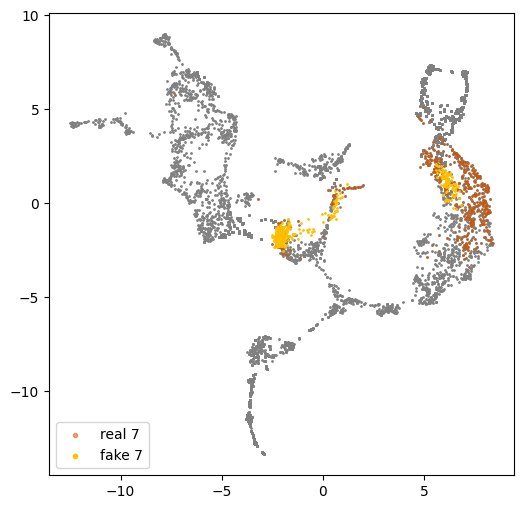

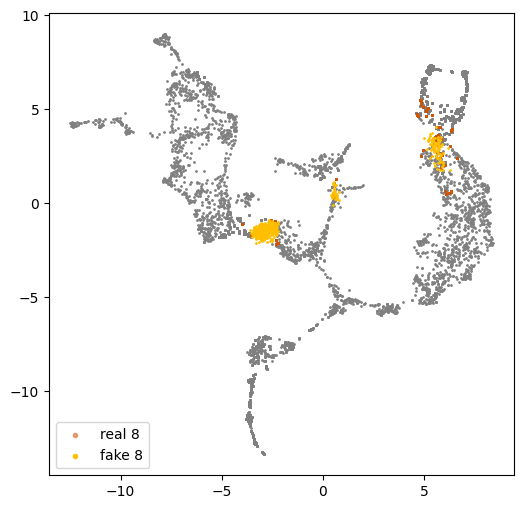

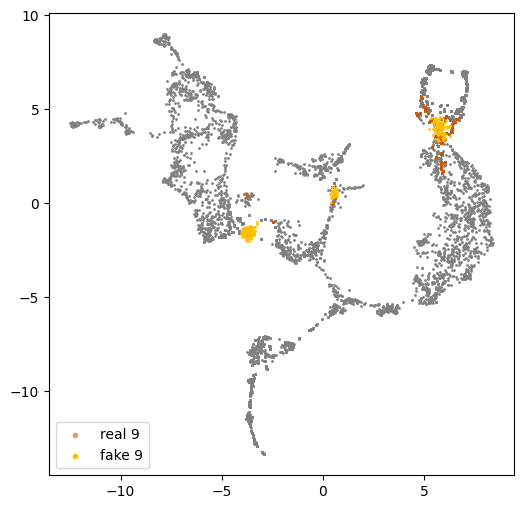

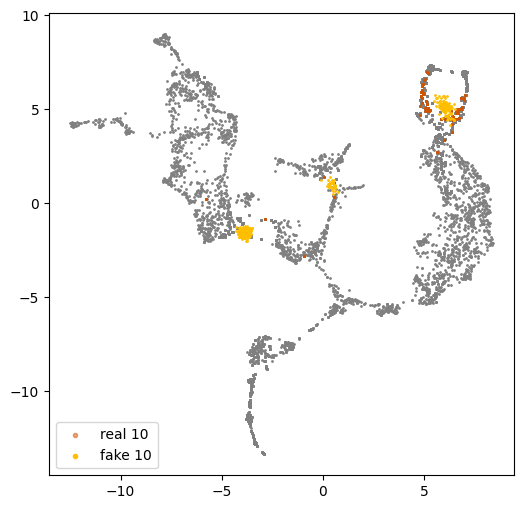

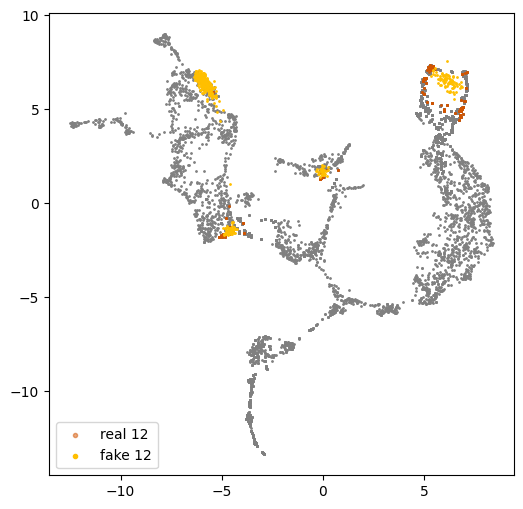

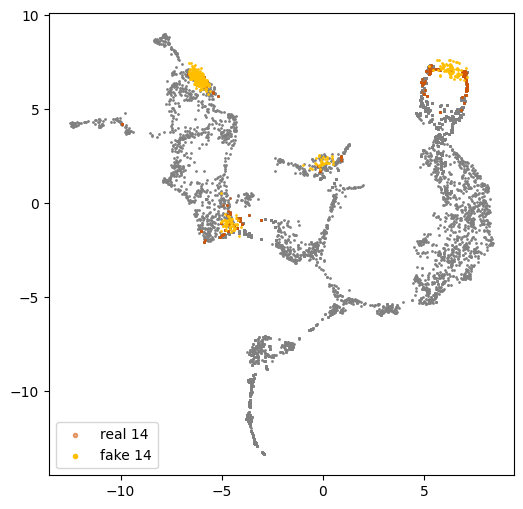

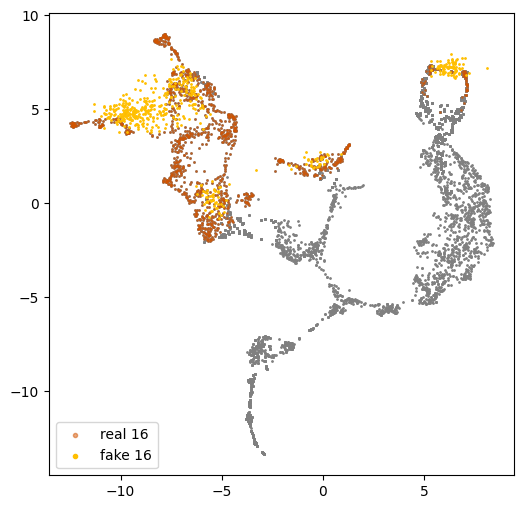

In [18]:
vi.visualize_generated_populations(data_lst,fore_base,time_steps,save_path='./embryo_results/generated_populations_backbone')

processed: 400: 100%|██████████| 400/400 [2:04:03<00:00, 18.61s/it, loss=72.8320196240063, loss_back=72.8320196240063]      


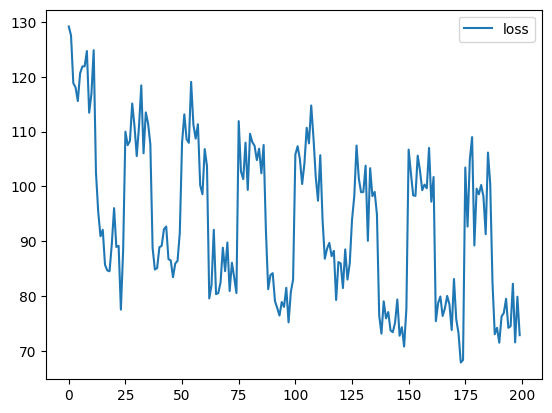

In [19]:
sb_object.fine_tune(change=25)
# sb_object.finetuning_load('model_history/embryo/fine_tuned.pt')

In [20]:
fore_ft=sb_object.eval_fore(data_lst[0].cuda().double(),sb_object.v_fore_fine_tuned)

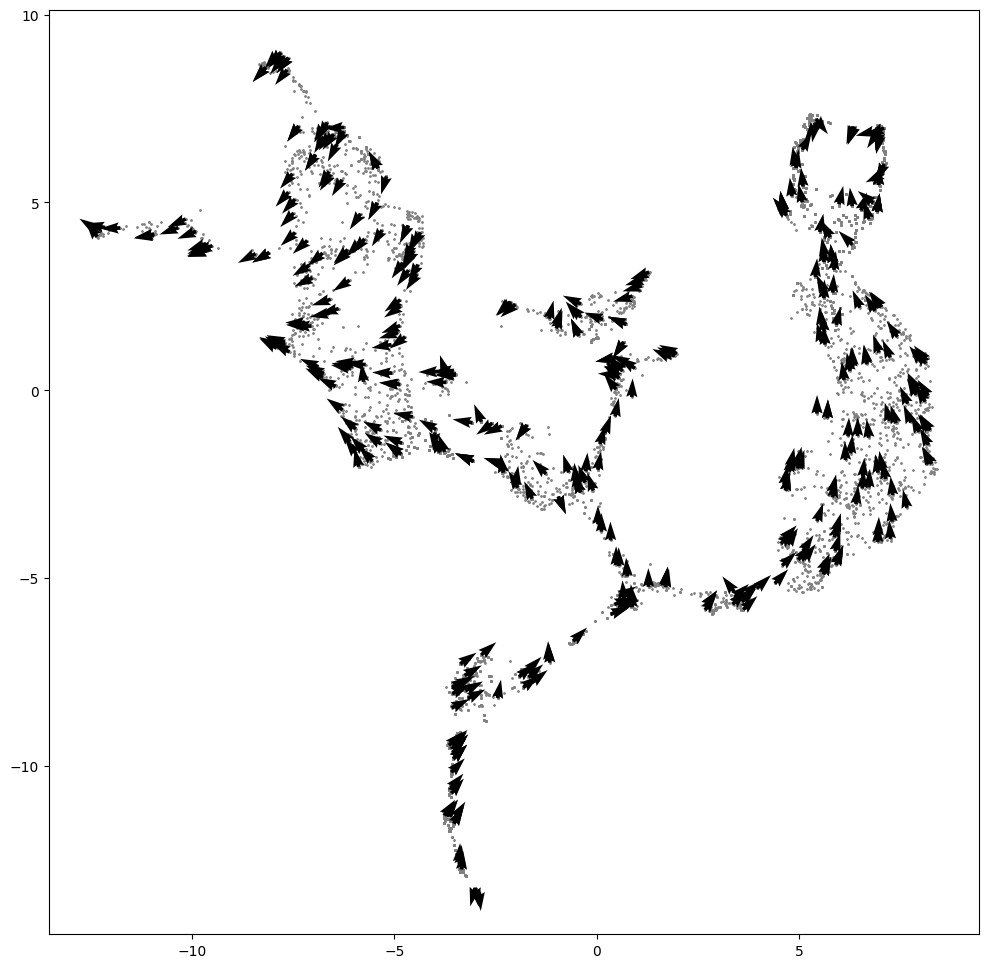

In [21]:
vi.visualize_drift_func(data_lst,np.concatenate(data_lst),sb_object,meta,save_path='./embryo_results/drift_fine_tuned',fine_tuned=True,xg_lower_bound=-15,xg_upper_bound=10,yg_lower_bound=-15,yg_upper_bound=10)

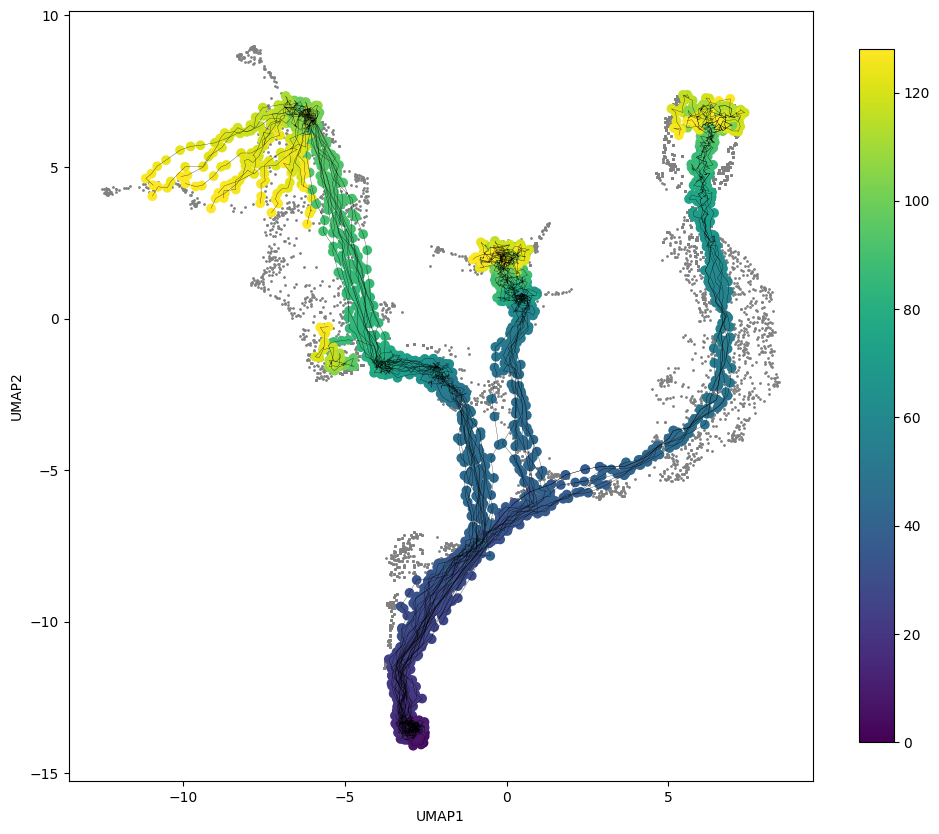

In [22]:
vi.visualize_generated_trajectories(data_lst,fore_ft,save_path='./embryo_results/generated_trajectories_fine_tuned')

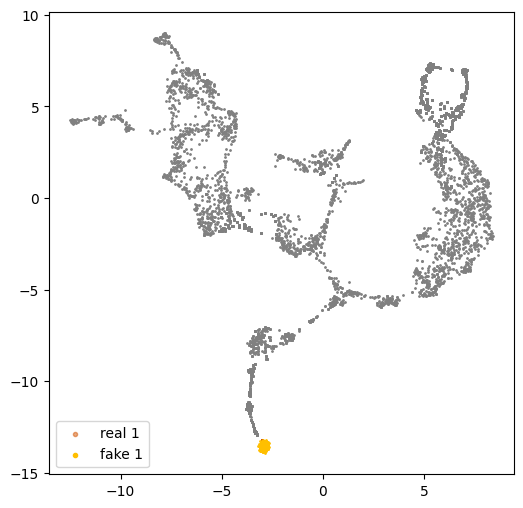

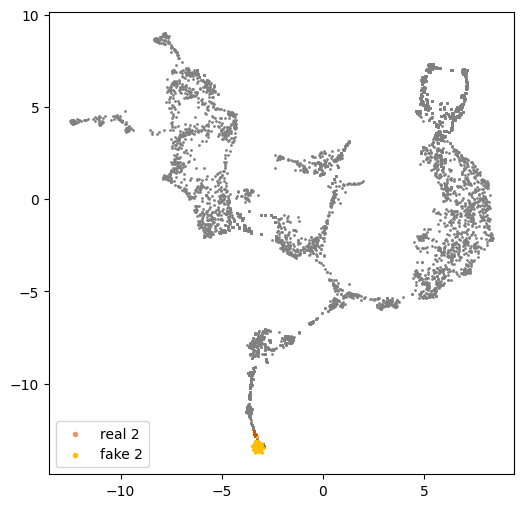

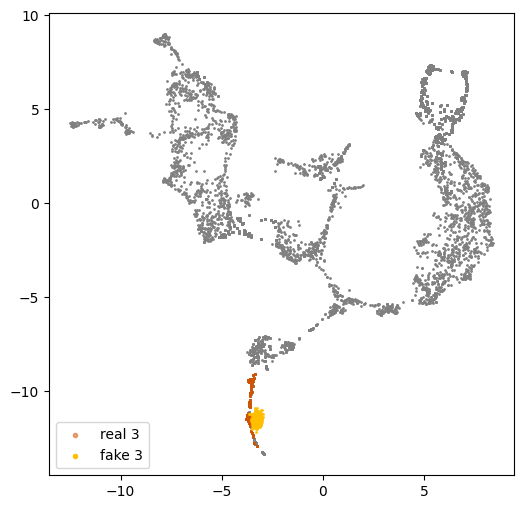

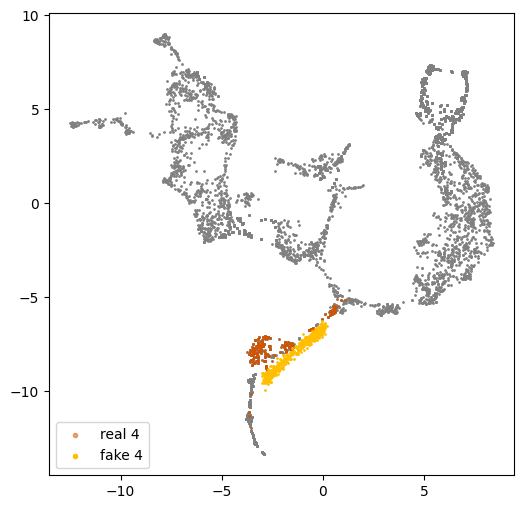

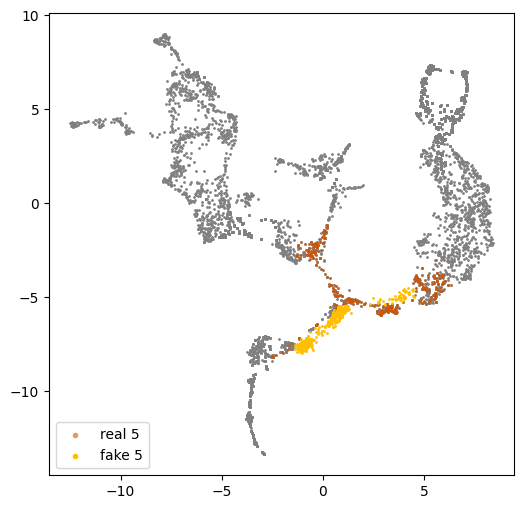

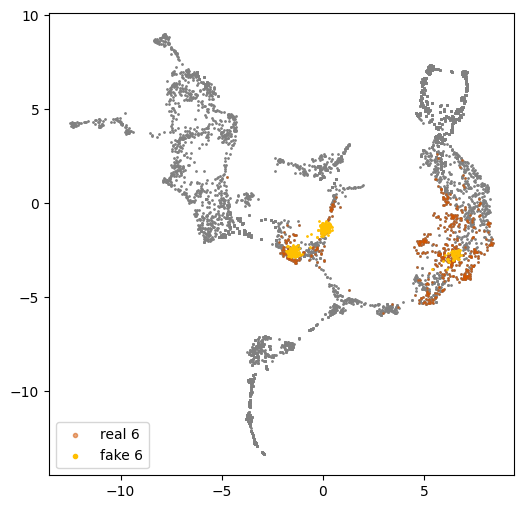

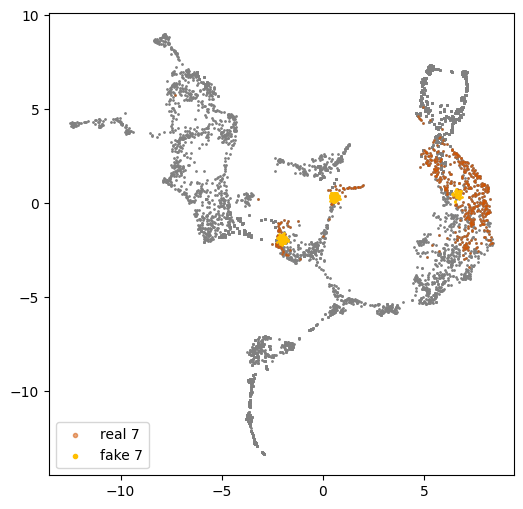

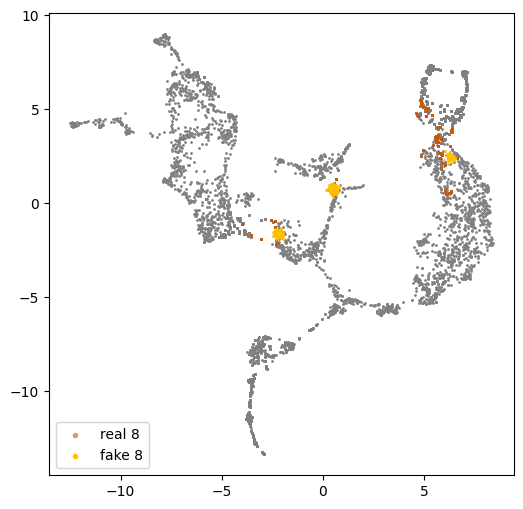

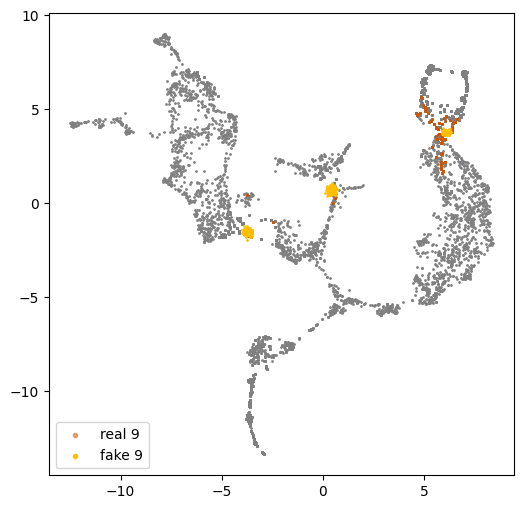

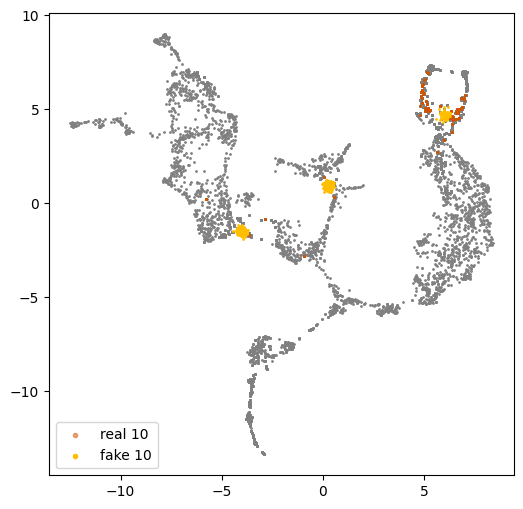

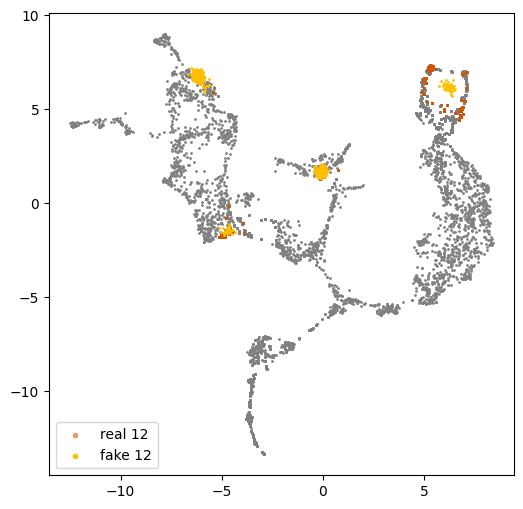

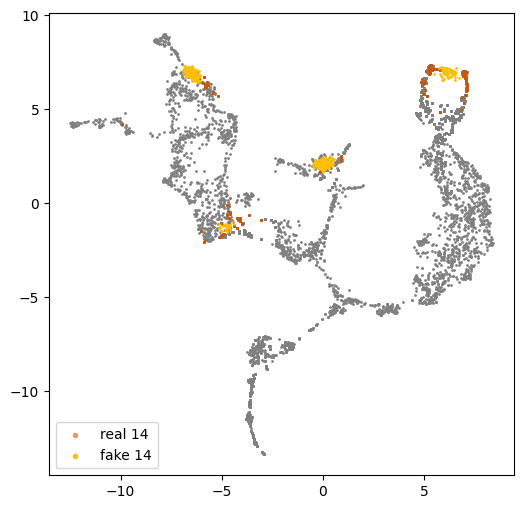

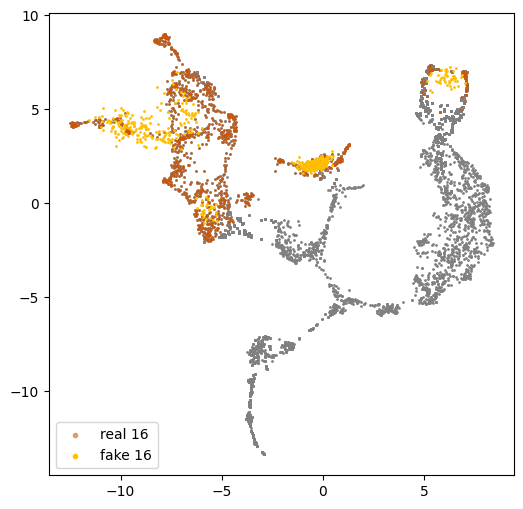

In [23]:
vi.visualize_generated_populations(data_lst,fore_ft,time_steps,save_path='./embryo_results/generated_populations_fine_tuned')

In [24]:
from geomloss import SamplesLoss
ot_solver = SamplesLoss("sinkhorn", p = 2, blur = 0.1, scaling = 0.7,backend='auto')

for week,data in enumerate(data_lst[1:]):
    data = torch.tensor(data, dtype=torch.float32).contiguous().cuda()
    back_bone_fake_data = torch.tensor(fore_base[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("backbone real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, back_bone_fake_data).item())
    fine_tune_fake_data = torch.tensor(fore_ft[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
    print("finetuned real" + str(time_steps[week+1]) + "-fake" + str(time_steps[week+1]),ot_solver(data, fine_tune_fake_data).item())

/tmp/ipykernel_16902/3531887930.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_16902/3531887930.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  back_bone_fake_data = torch.tensor(fore_base[time_steps[week+1]*steps_each_day], dtype=torch.float32).contiguous().cuda()
/tmp/ipykernel_16902/3531887930.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fine_tune_fake_data = torch.tensor(fore_ft[time_steps[week+1]*steps_each_day], dtype=torch.float32).con

backbone real1-fake1 0.04397912696003914
finetuned real1-fake1 0.0538787804543972
backbone real2-fake2 0.0315217599272728
finetuned real2-fake2 0.22798937559127808
backbone real3-fake3 0.2720527946949005
finetuned real3-fake3 0.7576707601547241
backbone real4-fake4 1.0861787796020508
finetuned real4-fake4 0.944008469581604
backbone real5-fake5 7.085737228393555
finetuned real5-fake5 5.9717559814453125
backbone real6-fake6 14.095511436462402
finetuned real6-fake6 14.659096717834473
backbone real7-fake7 26.249645233154297
finetuned real7-fake7 20.080493927001953
backbone real8-fake8 27.548799514770508
finetuned real8-fake8 17.254680633544922
backbone real9-fake9 35.6733283996582
finetuned real9-fake9 22.908496856689453
backbone real10-fake10 38.444854736328125
finetuned real10-fake10 25.043792724609375
backbone real12-fake12 32.952659606933594
finetuned real12-fake12 25.180007934570312
backbone real14-fake14 24.34703826904297
finetuned real14-fake14 16.76486587524414
backbone real16-fake